# Model module tutorial

This tutorial is a part of Model module guide. Here, we explore how you can use the Pytorch wrapper to use your Pytorch deep learning models in the benchmark.

In [3]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import sys
sys.path.insert(0,'../../')

In [4]:
# Python packages
import gc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [5]:
# Pytorch imports
import torch

In [6]:
# Benchmark modules
from OpenDenoising import data
from OpenDenoising import model
from OpenDenoising import evaluation

Using TensorFlow backend.
W0902 11:12:33.345944 140435191191360 deprecation_wrapper.py:119] From ../../model/tf_model.py:15: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [7]:
def display_results(clean_imgs, noisy_imgs, rest_images, name):
    """Display denoising results."""
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    
    plt.suptitle("Denoising results using {}".format(name))

    for i in range(5):
        axes[i, 0].imshow(np.squeeze(clean_imgs[i]), cmap="gray")
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Ground-Truth")

        axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Noised Image")

        axes[i, 2].imshow(np.squeeze(rest_imgs[i]), cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Restored Images")

In [8]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

In [9]:
# Training images generator
train_generator = data.DatasetFactory.create(path="../../tmp//BSDS500/Train",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             preprocessing=[partial(data.gen_patches, patch_size=40),
                                                            partial(data.dncnn_augmentation, aug_times=1)],
                                             name="BSDS_Train")

In [10]:
# Validation images generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             name="BSDS_Valid")

# Pytorch Model <a class="anchor" id="pytorch-model"></a> 
---

# Navigation
---

* [Pytorch Model](#pytorch-model)
    * [Charging a model](#pytorch-charging-a-model)
        * [Charging from a Class](#pytorch-charging-class)
        * [Charging from a file](#pytorch-charging-file)
    * [Running Inference](#pytorch-running-inference)
    * [Training a PytorchModel](#pytorch-training)

## Charging a model <a class="anchor" id="pytorch-charging-a-model"></a> 
---

To charge a model, you can either specify the path to a ".pth" or ".ph" file using "__model_path__" argument, or an instance of a class inheriting from [torch.nn.Module](https://pytorch.org/docs/stable/nn.html) class using "__model_function__" argument.

The ".ph"/".pth" files need to be saved from the entire model, that is, an instance of a class which inherits from torch.nn.Module (for more information, look at [Pytorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).

For the "__model_function__" argument, you need to specify a Pytorch model class, which inherits from torch.nn.Module.

### Charging from a Class <a class="anchor" id="pytorch-charging-class"></a> 

Consider the following implementation of DnCNN on Pytorch (code based on [this Github page](https://github.com/SaoYan/DnCNN-PyTorch)),

```Python
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1):
        super(DnCNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                      padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                    padding=1, bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                                padding=1, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return out
```

You can charge your model by passing it to the "__model_function__" argument. If you need to pass any optional arguments to the class init function, you can do so by using kwargs,

In [11]:
torch_ex1 = model.PytorchModel(model_name="dncnn_pytorch", logdir="../../training_logs/Pytorch")
torch_ex1.charge_model(model_function=model.architectures.pytorch.DnCNN, depth=17)

### Charging from a file <a class="anchor" id="pytorch-charging-file"></a> 

To charge a model from a file, you need to save it with extension ".pt" or ".pth". Important to mention, you need to save your whole model, and not only its state dict.

In [12]:
torch_ex2 = model.PytorchModel(model_name="dncnn_pytorch", logdir="../../training_logs/Pytorch")
torch_ex2.charge_model(model_path="./Additional Files/Pytorch Models/dncnn.pth", depth=17)

## Running inference <a class="anchor" id="pytorch-running-inference"></a> 
---

Since PytorchModel implements "__call__" function, inference can be done by simply using the instance as a function. Moreover, it is important to remark that Pytorch models only accept __NCHW__ (batch size - channel - height - width) data format. To overcome this issue, the "__call__" function automatically handles conversion between __NCHW__ and __NHWC__. In all cases, you should expect the shape of inputs to be equal to the output shape.

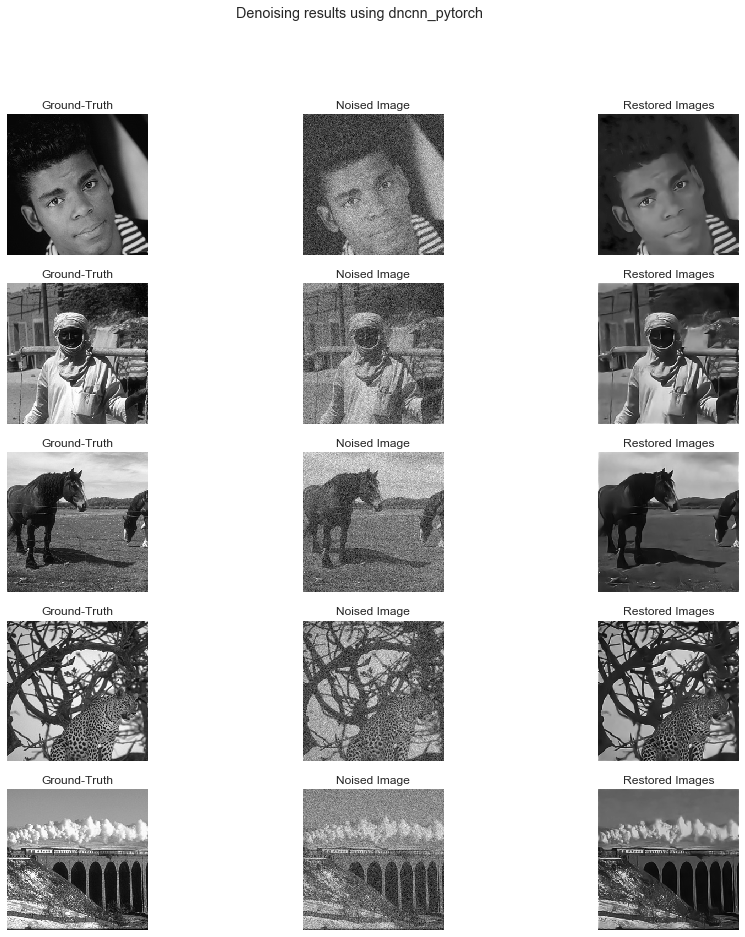

In [13]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = torch_ex2(noisy_imgs)
# Display results
display_results(clean_imgs, noisy_imgs, rest_imgs, str(torch_ex2))

### Training a Pytorch Model <a class="anchor" id="pytorch-training"></a> 
---

To train a Pytorch model, you need to specify at least one dataset (for training, as evaluation is optional). The rest of the parameters is discussed bellow,

#### __n_epochs (int)__
---

Number of training epochs.

#### __n_stages (int)__
---

Number of batches drawn from the dataset at each epoch. The total number of iterations corresponds to

$$n_{iterations} = n_{epochs} \times n_{stages}$$

#### __optimizer_name (str)__
---

Name of the optimizer's class (Take a look on [Pytorch's documentation](https://pytorch.org/docs/stable/optim.html)). 

#### __metrics (list)__
---

List of metric functions. These functions should have two inputs, two instances of 'numpy.ndarray' class. It outputs a float corresponding to the metric computed on those two arrays. For more information, take a look on the Benchmarking module.

#### __kcallbacks (list)__
---
List of callbacks. Take a look on the evaluation documentation.

#### __loss (torch.nn.modules.loss)__
---

Pytorch [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions).

#### __valid_steps (int)__
---

Number of validation batches drawn at the end of each epoch.

In [ ]:
torch_ex3 = model.PytorchModel(model_name="dncnn_pytorch", logdir="../../training_logs/Pytorch")
torch_ex3.charge_model(model_function=model.architectures.pytorch.DnCNN, depth=17)
torch_ex3.train(train_generator=train_generator,
                valid_generator=valid_generator,
                n_epochs=100,
                n_stages=465,
                learning_rate=1e-3,
                optimizer_name="Adam",
                metrics=[evaluation.psnr,
                         evaluation.ssim,
                         evaluation.mse],
                kcallbacks=[evaluation.DnCNNSchedule(),
                            evaluation.CheckpointCallback(torch_ex3, monitor="val_PSNR"),
                            evaluation.TensorboardImage(valid_generator, torch_ex3)],
                loss=torch.nn.MSELoss(reduction="sum"),
                valid_steps=10)